In [40]:
# Imports + all input data + tunable constants.

from itertools import product as cartesian_product
import math
import pandas as pd
from IPython.display import display  # to show tables nicely in notebooks

# ---- Tunable constants (assumptions) ----
STAGING_DAYS_CD = 3   # average CD staging time in days (Little's Law for cross-dock)
GAMMA_RF = 5          # RF explosion factor: 1 reserve load -> 5 smaller forward loads

# ---- Sets ----
products = [1, 2, 3, 4, 5, 6]
flows = [1, 2, 3, 4]  # 1=CD, 2=R, 3=RF, 4=F
flow_name = {1: "CD", 2: "R", 3: "RF", 4: "F"}
areas = ["CD", "R", "F"]

# ---- Table 11.1 ----
# Treat "Annual demand" as unit loads per year (consistent with the cost tables)
D = {1: 10000, 2: 15000, 3: 25000, 4: 2000, 5: 1500, 6: 95000}   # annual demand (unit loads)
S = {1: 50, 2: 50, 3: 50, 4: 50, 5: 50, 6: 150}                 # order cost ($/order)
P = {1: 500, 2: 650, 3: 350, 4: 250, 5: 225, 6: 150}            # price per unit load ($)
c_rate = {i: 0.10 for i in products}                            # carrying cost rate
space = {1: 10, 2: 15, 3: 25, 4: 10, 5: 12, 6: 13}              # m² per unit load

# RF reserve dwell fraction (only relevant if assigned to RF)
# NOTE: As stated, only 3 (20%) and 6 (100%) have nonzero reserve dwell when in RF.
alpha_reserve_RF = {1: 0.0, 2: 0.0, 3: 0.20, 4: 0.0, 5: 0.0, 6: 1.0}

# ---- Table 11.2 (handling cost per unit load) ----
handling_table = {
    1: {1: 0.0707, 2: 0.0849, 3: 0.1061, 4: 0.0778},
    2: {1: 0.0203, 2: 0.2023, 3: 0.2023, 4: 0.2023},
    3: {1: 0.0267, 2: 0.0420, 3: 0.0054, 4: 0.0481},
    4: {1: 0.3354, 2: 0.5590, 3: 1.0062, 4: 0.0671},
    5: {1: 0.4083, 2: 0.6804, 3: 1.2248, 4: 0.8165},
    6: {1: 0.0726, 2: 0.0871, 3: 0.1088, 4: 0.0798},
}
c_handling = {(i, f): handling_table[i][f] for i in products for f in flows}

# ---- Table 11.3 (storage cost per unit load per year) ----
storage_table = {
    1: {1: 20, 2: 5,  3: 10, 4: 15},
    2: {1: 15, 2: 5,  3: 10, 4: 10},
    3: {1: 4,  2: 20, 3: 1,  4: 9},
    4: {1: 5,  2: 4,  3: 5,  4: 1},
    5: {1: 15, 2: 25, 3: 45, 4: 30},
    6: {1: 20, 2: 5,  3: 10, 4: 15},
}
c_storage = {(i, f): storage_table[i][f] for i in products for f in flows}

# ---- Table 11.4 + total capacity ----
area_bounds = {"CD": (0, 15000), "R": (35000, 75000), "F": (35000, 75000)}
TOTAL_WAREHOUSE_CAP = 100_000  # "up to"

# ---- Table 11.5 (levels) ----
levels = {"CD": 1, "R": 1, "F": 1}


In [41]:
# EOQ and derived average on-hand/dwell (per unit load)
def eoq(i: int) -> float:
    # H ($/load-year) = price * carrying rate
    H = P[i] * c_rate[i]
    return math.sqrt(2 * D[i] * S[i] / H)

def avg_on_hand(i: int) -> float:
    # Standard EOQ assumption: average cycle stock = Q/2
    return 0.5 * eoq(i)

def dwell_years(i: int) -> float:
    return avg_on_hand(i) / D[i]

def dwell_days(i: int) -> float:
    return dwell_years(i) * 365.0

df_eoq = pd.DataFrame(
    [{"Product": i,
      "EOQ (loads)": eoq(i),
      "Avg on-hand (loads)": avg_on_hand(i),
      "Avg dwell (days)": dwell_days(i)} for i in products]
)
display(df_eoq.round(3))


,Product,EOQ (loads),Avg on-hand (loads),Avg dwell (days)
0,1,141.421,70.711,2.581
1,2,151.911,75.955,1.848
2,3,267.261,133.631,1.951
3,4,89.443,44.721,8.162
4,5,81.650,40.825,9.934
5,6,1378.405,689.202,2.648


In [42]:
def avg_load_equivalents(i: int, f: int) -> float:
    """
    Average 'load equivalents' for product i in flow f,
    used for both storage cost scaling and m² consumption.
    """
    if f == 1:  # Cross-dock: Little's Law with staging days
        return D[i] * (dwell_days(i) / 365.0)
    elif f in (2, 4):  # Pure Reserve or pure Forward
        return eoq(i) / 2
    elif f == 3:  # RF: split between Reserve and Forward with explosion in forward
        alpha = alpha_reserve_RF[i]
        base = eoq(i)/2
        # total load-equivalents stored across areas
        return alpha * base + GAMMA_RF * (1 - alpha) * base
    else:
        raise ValueError("Unknown flow")

def area_use_by_area(i: int, f: int) -> dict:
    """
    m² used by product i in each functional area for flow f.
    """
    s = space[i] / levels["R"]  # levels are 1 here, kept for completeness
    use = {"CD": 0.0, "R": 0.0, "F": 0.0}
    if f == 1:
        use["CD"] = avg_load_equivalents(i, f) * s
    elif f == 2:
        use["R"]  = avg_load_equivalents(i, f) * s
    elif f == 4:
        use["F"]  = avg_load_equivalents(i, f) * s
    elif f == 3:
        base  = avg_on_hand(i)
        alpha = alpha_reserve_RF[i]
        I_R = alpha * base
        I_F_equiv = GAMMA_RF * (1 - alpha) * base
        use["R"] = I_R * s
        use["F"] = I_F_equiv * s
    return use

def area_coeff(i: int, f: int, a: str) -> float:
    """Coefficient for area capacity constraint: m² used in area a if product i chooses flow f."""
    return area_use_by_area(i, f)[a]

def annual_cost_for_product(i: int, f: int) -> dict:
    # Handling cost scales with annual throughput; table gives $ per unit load in flow f
    handling = D[i] * c_handling[(i, f)]
    # Storage cost scales with average load equivalents; table gives $ per load-year in flow f
    storage  = avg_load_equivalents(i, f) * c_storage[(i, f)]
    return {"handling": handling, "storage": storage, "total": handling + storage}

def compute_area_consumption(assignment: dict) -> dict:
    cons = {"CD": 0.0, "R": 0.0, "F": 0.0}
    for i, f in assignment.items():
        use = area_use_by_area(i, f)
        for a in areas:
            cons[a] += use[a]
    return cons

def choose_area_sizes(cons: dict):
    """
    Given consumption by area, pick the smallest feasible area sizes satisfying:
      - per-area lower/upper bounds (Table 11.4)
      - total cap <= TOTAL_WAREHOUSE_CAP
    """
    sizes = {}
    for a in areas:
        lb, ub = area_bounds[a]
        need = cons[a]
        size_a = max(lb, need)
        if size_a > ub + 1e-9:
            return False, None  # infeasible requested consumption vs bounds
        sizes[a] = size_a

    # Check overall cap
    if sum(sizes.values()) > TOTAL_WAREHOUSE_CAP + 1e-9:
        return False, None

    return True, sizes

def evaluate_assignment(assignment: dict):
    cons = compute_area_consumption(assignment)
    feas, sizes = choose_area_sizes(cons)
    rows = []
    total_cost = 0.0
    for i, f in assignment.items():
        comp = annual_cost_for_product(i, f)
        rows.append({
            "Product": i,
            "Flow": flow_name[f],
            "Handling Cost": comp["handling"],
            "Storage Cost":  comp["storage"],
            "Total Cost":    comp["total"],
        })
        total_cost += comp["total"]
    df = pd.DataFrame(rows)
    return feas, sizes, total_cost, df, cons


In [43]:
def compute_area_consumption(assignment:dict) -> dict:
    cons = {"CD":0.0, "R":0.0, "F":0.0}
    for i, f in assignment.items():
        use = area_use_by_area(i,f)
        for a in areas:
            cons[a] += use[a]
    return cons

def choose_area_sizes(cons:dict):
    sizes = {}
    total = 0.0
    for a in areas:
        lb, ub = area_bounds[a]
        need = cons[a]
        size_a = max(lb, need)
        if size_a > ub + 1e-9:
            return None
        sizes[a] = size_a
        total += size_a
    if total > TOTAL_WAREHOUSE_CAP + 1e-9:
        return None
    return sizes

def evaluate_assignment(assignment:dict):
    cons = compute_area_consumption(assignment)
    sizes = choose_area_sizes(cons)
    if sizes is None:
        return False, None, float("inf"), None, None

    rows = []
    total_cost = 0.0
    for i, f in assignment.items():
        comp = annual_cost_for_product(i,f)
        rows.append({
            "Product": i,
            "Flow": flow_name[f],
            "Handling Cost": comp["handling"],
            "Storage Cost":  comp["storage"],
            "Total Cost":    comp["total"]
        })
        total_cost += comp["total"]

    df = pd.DataFrame(rows)
    return True, sizes, total_cost, df, cons


In [44]:
try:
    import pulp as pl

    m = pl.LpProblem("ForwardReserve_AreaSizing", pl.LpMinimize)

    # Variables
    x = pl.LpVariable.dicts("x", (products, flows), lowBound=0, upBound=1, cat=pl.LpBinary)
    A = pl.LpVariable.dicts("A", areas, lowBound=0, cat=pl.LpContinuous)

    # Objective: sum_i sum_f x_if * (handling_i,f + storage_i,f)
    m += pl.lpSum(
        x[i][f] * (
            D[i] * c_handling[(i, f)] +
            avg_load_equivalents(i, f) * c_storage[(i, f)]
        )
        for i in products for f in flows
    )

    # Each product assigned to exactly one flow
    for i in products:
        m += pl.lpSum(x[i][f] for f in flows) == 1, f"assign_{i}"

    # Area capacity constraints: for each area a,
    #   sum_i sum_f x_if * area_coeff(i,f,a) <= A_a
    for a in areas:
        m += pl.lpSum(x[i][f] * area_coeff(i, f, a)
                       for i in products for f in flows) <= A[a], f"area_cap_{a}"

    # Area lower/upper bounds
    for a in areas:
        lb, ub = area_bounds[a]
        m += A[a] >= lb, f"lb_{a}"
        m += A[a] <= ub, f"ub_{a}"

    # Total building cap
    m += pl.lpSum(A[a] for a in areas) <= TOTAL_WAREHOUSE_CAP, "total_cap"

    # Solve
    _ = m.solve(pl.PULP_CBC_CMD(msg=False))

    # Report
    status = pl.LpStatus[m.status]
    print("Solver status:", status)
    if status != "Optimal":
        # Fall back: show best found (if any)
        pass

    # Extract solution
    sol_assign = {i: max(flows, key=lambda f: pl.value(x[i][f])) for i in products}
    sol_sizes  = {a: pl.value(A[a]) for a in areas}

    feasible, sized, tot_cost, df_cost, cons = evaluate_assignment(sol_assign)

    print("\n=== Optimal product-to-flow assignment ===")
    display(pd.DataFrame(
        [{"Product": i, "Assigned Flow": flow_name[sol_assign[i]]} for i in products]
    ).sort_values("Product"))

    print("\n=== Area consumption (m²) from assignment ===")
    display(pd.DataFrame([cons]).T.rename(columns={0: "Consumption (m²)"}))

    print("\n=== Chosen area sizes (m²) ===")
    display(pd.DataFrame([sol_sizes]).T.rename(columns={0: "Size (m²)"}))

    print("\n=== Annual cost breakdown ===")
    display(df_cost.sort_values("Product").reset_index(drop=True))
    print(f"\nTotal annual cost: {tot_cost:,.2f} $")

except Exception as e:
    print("PuLP not available or MILP solve skipped. Details:", e)


Solver status: Optimal

=== Optimal product-to-flow assignment ===


,Product,Assigned Flow
0,1,R
1,2,CD
2,3,RF
3,4,F
4,5,CD
5,6,R



=== Area consumption (m²) from assignment ===


,Consumption (m²)
CD,1629.229737
R,10334.891575
F,13810.275691



=== Chosen area sizes (m²) ===


,Size (m²)
CD,1629.2297
R,35000.0000
F,35000.0000



=== Annual cost breakdown ===


,Product,Flow,Handling Cost,Storage Cost,Total Cost
0,1,R,849.00,353.553391,1202.553391
1,2,CD,304.50,1139.331788,1443.831788
2,3,RF,135.00,561.248608,696.248608
3,4,F,134.20,44.721360,178.921360
4,5,CD,612.45,612.372436,1224.822436
5,6,R,8274.50,3446.012188,11720.512188



Total annual cost: 16,466.89 $


# 11.5 Warehouse Block Layout Design (6-Department Starter)
**Scope (Robustness target):** Handle at least these 6 departments  
1) Inbound Dock, 2) Receiving/Staging, 3) Pallet Reserve Storage (Bulk),  
4) Packing / Wrap / Banding, 5) Outbound Staging (Parcel + 2-Man combined),  
6) Shipping Dock.

**Goal:** For three layout patterns (I, L, U), place rectangular departments inside a bounding facility, respect fixed dock positions, avoid overlap, and **minimize total flow-weighted rectilinear (Manhattan) travel** between department centroids.

**Modeling approach (MILP):**
- We translate Muther SLP adjacency codes (E/A/I/O/U) into **quantitative flows** (4/3/2/1/0). This follows the common practice of mapping qualitative closeness to pairwise interaction weights, consistent with the literature (e.g., Heragu et al., 2005).
- To keep areas **exact** yet linear, we precompute a small set of **aspect-ratio options** for each department. A single binary choice selects one (width, height) combination with `width × height = target_area`.
- **Non-overlap** is enforced with the classic disjunctive Big-M formulation using four binaries per pair (left/right/above/below) and `L+R+B+T = 1`.
- **Distance** is rectified via absolute-value linearization: introduce `dx_ij, dy_ij` with `dx_ij ≥ x_i − x_j` and `dx_ij ≥ x_j − x_i` (similarly for `dy_ij`); objective is ∑ f_ij (dx_ij + dy_ij).

**Patterns (dock placement constraints):**
- **I-shaped:** Inbound dock fixed to the **left wall (center)**; Shipping dock fixed to the **right wall (center)** of a long rectangle.
- **L-shaped:** Inbound fixed to the **bottom wall (left wing)**; Shipping fixed to the **right wall (top wing)** of a moderately rectangular block (we emulate an L-flow by orthogonal dock placement).
- **U-shaped:** Both docks on the **same wall (left)** at **lower** (Inbound) and **upper** (Shipping) segments, encouraging a U-flow.

**Assessment settings:**
- Gurobi requested; we set `MIPGap = 0.05` as a target.
- Clear visualizations using Matplotlib.

**Reference:**  
Heragu, S. S., Du, L., Mantel, R. J., & Schuur, P. C. (2005). *Mathematical model for warehouse design and product allocation*. IJPR, 43(2), 327–38. https://doi.org/10.1080/00207540412331285841

In [45]:
# If you use a different solver, adapt here; Gurobi requested by spec.
try:
    !pip install gurobipy
    # --- IGNORE ---
    import gurobipy as gp
    from gurobipy import GRB
except Exception as e:
    raise RuntimeError(
        "This notebook is written for Gurobi (gurobipy). "
        "Please install & license Gurobi to run. Error: {}".format(e)
    )

import math
import itertools
import matplotlib.pyplot as plt
from dataclasses import dataclass


## Data: Areas & SLP mapping

**Areas (m²)** from Table 11.6 (restricted to the 6-department subset; Outbound Staging is aggregated):
- Inbound Dock: 2,640  
- Receiving/Staging: 5,280  
- Pallet Reserve Storage (Bulk): 46,340  
- Packing / Wrap / Banding: 3,520  
- Outbound Staging (Parcel + 2-Man): 3,520 + 5,280 = **8,800**  
- Shipping Dock: 3,520

**SLP mapping to flows:**  
We convert Muther SLP codes to numeric flows as:  
`E=4, A=3, I=2, O=1, U=0`.  
For the aggregated **Outbound Staging**, where two original rows existed (Parcel & 2-Man), we take the **max** code against any counterpart (equivalent to assuming aggregation preserves the strongest interaction).  
This yields a chain of strong interactions (a classic flow):  
Inbound ↔ Receiving (E), Receiving ↔ Bulk (I), Bulk ↔ Packing (E), Packing ↔ Staging (E), Staging ↔ Shipping (E).  
All other pairs default to lower or zero flow if their codes were U/O in the SLP.

We will use these flows directly as **unit-load intensities**; with unit transport cost per meter, the objective becomes total flow-weighted distance.


In [46]:
# ===== REPLACE YOUR "Cell 4 — Data Initialization (Code)" WITH THIS BLOCK =====

# ------- Departments & areas (m^2) : full list from Table 11.6 -------
AREAS = {
    "Cross-Dock": 3520,
    "Empty Pallets & Dunnage": 880,
    "Inbound Dock": 2640,
    "Maintenance & Battery Charge": 1320,
    "Outbound Staging — 2-Man Delivery": 5280,
    "Outbound Staging — Parcel": 3520,
    "Oversize/Non-Standard Storage": 2640,
    "Packing / Wrap / Banding": 3520,
    "Pallet Reserve Storage (Bulk)": 46340,
    "QA & Technical Test": 1760,
    "Receiving/Staging": 5280,
    "Returns & WEEE": 2640,
    "Shipping Dock": 3520,
    "Spare Parts & Accessories Cage": 440,
}

DEPTS = list(AREAS.keys())

# ------- SLP code weights (Muther legend) -------
SLP_WEIGHT = {"E": 4, "A": 3, "I": 2, "O": 1, "U": 0, "X": -4}

# ------- Encode the full SLP adjacency matrix (only non-U entries listed) -------
# We list all pairs (i,j,code) where code ∈ {E,A,I,O}. All others are U by default.
slp_nonU = [
    # Inbound Dock row
    ("Inbound Dock", "Receiving/Staging", "E"),

    # Receiving/Staging row
    ("Receiving/Staging", "QA & Technical Test", "A"),
    ("Receiving/Staging", "Cross-Dock", "A"),
    ("Receiving/Staging", "Pallet Reserve Storage (Bulk)", "I"),
    ("Receiving/Staging", "Empty Pallets & Dunnage", "I"),

    # QA & Technical Test row
    ("QA & Technical Test", "Receiving/Staging", "A"),
    ("QA & Technical Test", "Returns & WEEE", "I"),

    # Cross-Dock row
    ("Cross-Dock", "Receiving/Staging", "A"),
    ("Cross-Dock", "Outbound Staging — Parcel", "A"),
    ("Cross-Dock", "Outbound Staging — 2-Man Delivery", "A"),
    ("Cross-Dock", "Shipping Dock", "A"),

    # Pallet Reserve Storage (Bulk) row
    ("Pallet Reserve Storage (Bulk)", "Receiving/Staging", "I"),
    ("Pallet Reserve Storage (Bulk)", "Packing / Wrap / Banding", "E"),
    ("Pallet Reserve Storage (Bulk)", "Maintenance & Battery Charge", "O"),

    # Oversize/Non-Standard Storage row
    ("Oversize/Non-Standard Storage", "Packing / Wrap / Banding", "I"),

    # Packing / Wrap / Banding row
    ("Packing / Wrap / Banding", "Pallet Reserve Storage (Bulk)", "E"),
    ("Packing / Wrap / Banding", "Oversize/Non-Standard Storage", "I"),
    ("Packing / Wrap / Banding", "Outbound Staging — Parcel", "E"),
    ("Packing / Wrap / Banding", "Outbound Staging — 2-Man Delivery", "E"),
    ("Packing / Wrap / Banding", "Empty Pallets & Dunnage", "O"),
    ("Packing / Wrap / Banding", "Returns & WEEE", "O"),

    # Outbound Staging — Parcel row
    ("Outbound Staging — Parcel", "Cross-Dock", "A"),
    ("Outbound Staging — Parcel", "Packing / Wrap / Banding", "E"),
    ("Outbound Staging — Parcel", "Shipping Dock", "E"),

    # Outbound Staging — 2-Man Delivery row
    ("Outbound Staging — 2-Man Delivery", "Cross-Dock", "A"),
    ("Outbound Staging — 2-Man Delivery", "Packing / Wrap / Banding", "E"),
    ("Outbound Staging — 2-Man Delivery", "Shipping Dock", "E"),

    # Shipping Dock row
    ("Shipping Dock", "Cross-Dock", "A"),
    ("Shipping Dock", "Outbound Staging — Parcel", "E"),
    ("Shipping Dock", "Outbound Staging — 2-Man Delivery", "E"),

    # Empty Pallets & Dunnage row
    ("Empty Pallets & Dunnage", "Receiving/Staging", "I"),
    ("Empty Pallets & Dunnage", "Packing / Wrap / Banding", "O"),

    # Maintenance & Battery Charge row
    ("Maintenance & Battery Charge", "Pallet Reserve Storage (Bulk)", "O"),

    # Returns & WEEE row
    ("Returns & WEEE", "QA & Technical Test", "I"),
    ("Returns & WEEE", "Packing / Wrap / Banding", "O"),

    # Spare Parts & Accessories Cage row
    # (all U; no entries here)
]

# ------- Build symmetric numeric flow matrix f[(i,j)] for i<j -------
import itertools

flows = {}
# initialize all to 0 (U)
for i, j in itertools.combinations(DEPTS, 2):
    flows[(i, j)] = 0

# apply non-U codes
for a, b, code in slp_nonU:
    if a not in AREAS or b not in AREAS:
        raise ValueError(f"Unknown department name in SLP pair: ({a}, {b})")
    i, j = sorted([a, b], key=lambda s: DEPTS.index(s))
    flows[(i, j)] = SLP_WEIGHT[code]

# Quick sanity checks
total_area = sum(AREAS.values())
num_pairs = len(list(itertools.combinations(DEPTS, 2)))
nonzero_pairs = sum(1 for k,v in flows.items() if v != 0)

print(f"Departments: {len(DEPTS)} (expected 14)")
print(f"Total area: {total_area:,.0f} m² (envelope should be ≳ this)")
print(f"Pairs: {num_pairs}, nonzero flows: {nonzero_pairs}")
# You can inspect a few key pairs:
for key in [
    ("Inbound Dock", "Receiving/Staging"),
    ("Packing / Wrap / Banding", "Outbound Staging — Parcel"),
    ("Outbound Staging — 2-Man Delivery", "Shipping Dock"),
    ("Pallet Reserve Storage (Bulk)", "Packing / Wrap / Banding"),
    ("QA & Technical Test", "Returns & WEEE"),
]:
    i, j = sorted(key, key=lambda s: DEPTS.index(s))
    print(f"{key[0]} <-> {key[1]} : flow {flows[(i,j)]}")


Departments: 14 (expected 14)
Total area: 83,300 m² (envelope should be ≳ this)
Pairs: 91, nonzero flows: 18
Inbound Dock <-> Receiving/Staging : flow 4
Packing / Wrap / Banding <-> Outbound Staging — Parcel : flow 4
Outbound Staging — 2-Man Delivery <-> Shipping Dock : flow 4
Pallet Reserve Storage (Bulk) <-> Packing / Wrap / Banding : flow 4
QA & Technical Test <-> Returns & WEEE : flow 2


## Facility footprint and dock placements (I / L / U)

We approximate each pattern with a **single rectangular envelope** of equal total area for fairness, differing only by **dock placement**:

- Total required area (departments only): 70,100 m².  
  We add ~20% space for aisles/circulation = **84,120 m²**.

We choose three envelopes near this area:
- **I-shaped (long):** `W=420 m, H=200 m` → 84,000 m² (AR ≈ 2.1)  
- **L-shaped (emulated via orthogonal dock placement):** `W=360 m, H=234 m` → 84,240 m² (AR ≈ 1.54)  
- **U-shaped (more square):** `W=290 m, H=290 m` → 84,100 m² (AR ≈ 1.0)

**Dock placement rules** (implemented by fixing (x,y) relationships):
- Left wall: `x = 0.5 * width`
- Right wall: `x = W - 0.5 * width`
- Bottom wall: `y = 0.5 * height`
- Top wall: `y = H - 0.5 * height`
- Center on a wall: use the wall rule above and set the other coordinate to `H/2` or `W/2` as needed.

Specifics:
- **I-shaped:** Inbound @ **left-wall center**, Shipping @ **right-wall center**
- **L-shaped:** Inbound @ **bottom-wall** (left wing: `x = 0.25W`), Shipping @ **right-wall** (upper wing: `y = 0.75H`)
- **U-shaped:** Both on **left wall**; Inbound @ lower (`y = 0.25H`), Shipping @ upper (`y = 0.75H`)


In [47]:
@dataclass
class LayoutSpec:
    name: str
    W: float
    H: float
    dock_rules: dict  # maps department -> {"x_rule": ..., "y_rule": ...}

def make_aspect_options(area, ratios=(0.5, 0.75, 1.0, 1.5, 2.0)):
    """
    For a given area, return a list of (w,h) options where w*h == area,
    parameterized by aspect ratio r = h/w.
    """
    opts = []
    for r in ratios:
        h = math.sqrt(area * r)
        w = area / h  # == sqrt(area / r)
        opts.append((w, h))
    return opts

def build_and_solve(layout: LayoutSpec, seed=0, miph_gap=0.05, time_limit=None, verbose=True):
    """
    Build and solve one layout MILP using Gurobi.
    Returns a dict with geometry and objective value.
    """
    gp.setParam("OutputFlag", 1 if verbose else 0)
    if time_limit is not None:
        gp.setParam("TimeLimit", float(time_limit))
    gp.setParam("MIPGap", float(miph_gap))

    mdl = gp.Model(f"WarehouseLayout_{layout.name}")

    # Variables per department i:
    # Center coordinates
    x = {i: mdl.addVar(lb=0.0, ub=layout.W, name=f"x[{i}]") for i in DEPTS}
    y = {i: mdl.addVar(lb=0.0, ub=layout.H, name=f"y[{i}]") for i in DEPTS}

    # Aspect option binaries and implied width/height
    aspects = {i: make_aspect_options(AREAS[i]) for i in DEPTS}
    z = { (i,k): mdl.addVar(vtype=GRB.BINARY, name=f"z[{i},{k}]")
          for i in DEPTS for k,_ in enumerate(aspects[i]) }
    w = {i: mdl.addVar(lb=0.0, ub=layout.W, name=f"w[{i}]") for i in DEPTS}
    h = {i: mdl.addVar(lb=0.0, ub=layout.H, name=f"h[{i}]") for i in DEPTS}

    # Select exactly one aspect option per department; define w,h as convex combo
    for i in DEPTS:
        mdl.addConstr(gp.quicksum(z[(i,k)] for k in range(len(aspects[i]))) == 1, name=f"one_aspect[{i}]")
        mdl.addConstr(
            w[i] == gp.quicksum(aspects[i][k][0] * z[(i,k)] for k in range(len(aspects[i]))),
            name=f"w_def[{i}]"
        )
        mdl.addConstr(
            h[i] == gp.quicksum(aspects[i][k][1] * z[(i,k)] for k in range(len(aspects[i]))),
            name=f"h_def[{i}]"
        )

    # Keep rectangles inside the facility
    for i in DEPTS:
        mdl.addConstr(x[i] >= 0.5 * w[i], name=f"x_left[{i}]")
        mdl.addConstr(x[i] <= layout.W - 0.5 * w[i], name=f"x_right[{i}]")
        mdl.addConstr(y[i] >= 0.5 * h[i], name=f"y_bottom[{i}]")
        mdl.addConstr(y[i] <= layout.H - 0.5 * h[i], name=f"y_top[{i}]")

    # Non-overlap: disjunctive Big-M with L+R+B+T = 1 for each unordered pair
    BIG_Mx = layout.W
    BIG_My = layout.H
    L = {}
    R = {}
    B = {}
    T = {}

    for i, j in itertools.combinations(DEPTS, 2):
        L[(i,j)] = mdl.addVar(vtype=GRB.BINARY, name=f"L[{i}|{j}]")  # i left of j
        R[(i,j)] = mdl.addVar(vtype=GRB.BINARY, name=f"R[{i}|{j}]")  # i right of j
        B[(i,j)] = mdl.addVar(vtype=GRB.BINARY, name=f"B[{i}|{j}]")  # i below j
        T[(i,j)] = mdl.addVar(vtype=GRB.BINARY, name=f"T[{i}|{j}]")  # i above j

        mdl.addConstr(L[(i,j)] + R[(i,j)] + B[(i,j)] + T[(i,j)] == 1, name=f"one_rel[{i}|{j}]")

        # i left of j
        mdl.addConstr(x[i] + 0.5*w[i] <= x[j] - 0.5*w[j] + BIG_Mx*(1 - L[(i,j)]), name=f"left[{i}|{j}]")
        # i right of j
        mdl.addConstr(x[j] + 0.5*w[j] <= x[i] - 0.5*w[i] + BIG_Mx*(1 - R[(i,j)]), name=f"right[{i}|{j}]")
        # i below j
        mdl.addConstr(y[i] + 0.5*h[i] <= y[j] - 0.5*h[j] + BIG_My*(1 - B[(i,j)]), name=f"below[{i}|{j}]")
        # i above j
        mdl.addConstr(y[j] + 0.5*h[j] <= y[i] - 0.5*h[i] + BIG_My*(1 - T[(i,j)]), name=f"above[{i}|{j}]")

    # Flow-weighted Manhattan distances (absolute value linearization)
    dx = {}
    dy = {}
    for i, j in itertools.combinations(DEPTS, 2):
        dx[(i,j)] = mdl.addVar(lb=0.0, name=f"dx[{i}|{j}]")
        dy[(i,j)] = mdl.addVar(lb=0.0, name=f"dy[{i}|{j}]")

        # |x_i - x_j|
        mdl.addConstr(dx[(i,j)] >= x[i] - x[j], name=f"dx1[{i}|{j}]")
        mdl.addConstr(dx[(i,j)] >= x[j] - x[i], name=f"dx2[{i}|{j}]")
        # |y_i - y_j|
        mdl.addConstr(dy[(i,j)] >= y[i] - y[j], name=f"dy1[{i}|{j}]")
        mdl.addConstr(dy[(i,j)] >= y[j] - y[i], name=f"dy2[{i}|{j}]")

    # Fixed dock placement rules by pattern
    def apply_rule(axis, dept, rule):
        # rule can be "left", "right", "bottom", "top", "center_x", "center_y", or a float value
        if axis == "x":
            if rule == "left":
                mdl.addConstr(x[dept] == 0.5 * w[dept], name=f"fix_left[{dept}]")
            elif rule == "right":
                mdl.addConstr(x[dept] == layout.W - 0.5 * w[dept], name=f"fix_right[{dept}]")
            elif rule == "center_x":
                mdl.addConstr(x[dept] == layout.W / 2.0, name=f"fix_cx[{dept}]")
            elif isinstance(rule, (int, float)):
                mdl.addConstr(x[dept] == float(rule), name=f"fix_xval[{dept}]")
        elif axis == "y":
            if rule == "bottom":
                mdl.addConstr(y[dept] == 0.5 * h[dept], name=f"fix_bottom[{dept}]")
            elif rule == "top":
                mdl.addConstr(y[dept] == layout.H - 0.5 * h[dept], name=f"fix_top[{dept}]")
            elif rule == "center_y":
                mdl.addConstr(y[dept] == layout.H / 2.0, name=f"fix_cy[{dept}]")
            elif isinstance(rule, (int, float)):
                mdl.addConstr(y[dept] == float(rule), name=f"fix_yval[{dept}]")

    for dept, rules in layout.dock_rules.items():
        if "x_rule" in rules: apply_rule("x", dept, rules["x_rule"])
        if "y_rule" in rules: apply_rule("y", dept, rules["y_rule"])

    # Objective: sum_{i<j} flow_ij * (dx_ij + dy_ij)
    obj = gp.quicksum(
        flows[(i,j)] * (dx[(i,j)] + dy[(i,j)])
        for i, j in itertools.combinations(DEPTS, 2)
    )
    mdl.setObjective(obj, GRB.MINIMIZE)

    mdl.optimize()

    # Collect solution
    sol = {
        "obj": mdl.objVal if mdl.status == GRB.OPTIMAL or mdl.status == GRB.SUBOPTIMAL else None,
        "W": layout.W, "H": layout.H,
        "x": {i: x[i].X for i in DEPTS},
        "y": {i: y[i].X for i in DEPTS},
        "w": {i: w[i].X for i in DEPTS},
        "h": {i: h[i].X for i in DEPTS},
        "status": mdl.status,
        "gap": mdl.MIPGap if hasattr(mdl, "MIPGap") else None
    }
    return sol


## Visualization helper

We draw the facility boundary and the placed rectangles (department blocks) with labels and dimensions.


In [48]:
def draw_layout(solution, title=None, figsize=(10, 7)):
    W, H = solution["W"], solution["H"]
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(0, W)
    ax.set_ylim(0, H)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title or "Layout")
    ax.set_xlabel("X (m)"); ax.set_ylabel("Y (m)")

    # Draw boundary
    ax.plot([0, W, W, 0, 0], [0, 0, H, H, 0], lw=2)

    # Draw rectangles
    for i in DEPTS:
        cx, cy = solution["x"][i], solution["y"][i]
        wi, hi = solution["w"][i], solution["h"][i]
        x0 = cx - wi/2.0
        y0 = cy - hi/2.0
        rect = plt.Rectangle((x0, y0), wi, hi, fill=False, lw=2)
        ax.add_patch(rect)
        ax.text(cx, cy, i, ha='center', va='center', fontsize=9, weight='bold')
        ax.text(cx, y0 + hi + 1.5, f"{wi:.1f}×{hi:.1f} m", ha='center', va='bottom', fontsize=8)

    # Quick legend with objective & gap (if available)
    obj = solution.get("obj", None)
    gap = solution.get("gap", None)
    subtitle = []
    if obj is not None:
        subtitle.append(f"Objective (flow-weighted m): {obj:,.0f}")
    if gap is not None and gap >= 0:
        subtitle.append(f"MIP gap: {gap*100:.1f}%")
    if subtitle:
        ax.text(0.01*W, 0.99*H, "\n".join(subtitle), va='top', ha='left', fontsize=9)

    plt.show()


## Define I, L, and U patterns (dock placements)

We plug the dock rules into `LayoutSpec`:
- **I:** Inbound → left wall + centered vertically; Shipping → right wall + centered vertically
- **L:** Inbound → bottom wall near left wing (`x = 0.25W`); Shipping → right wall near upper wing (`y = 0.75H`)
- **U:** Both docks on **left wall**; Inbound lower (`0.25H`), Shipping upper (`0.75H`)


In [49]:
I_layout = LayoutSpec(
    name="I-shaped",
    W=420.0, H=200.0,
    dock_rules={
        "Inbound Dock":  {"x_rule": "left",  "y_rule": "center_y"},
        "Shipping Dock": {"x_rule": "right", "y_rule": "center_y"},
    },
)

L_layout = LayoutSpec(
    name="L-shaped",
    W=360.0, H=234.0,
    dock_rules={
        "Inbound Dock":  {"x_rule": 0.25 * 360.0, "y_rule": "bottom"},      # bottom-left wing
        "Shipping Dock": {"x_rule": "right",        "y_rule": 0.75 * 234.0}, # right wall upper wing
    },
)

U_layout = LayoutSpec(
    name="U-shaped",
    W=290.0, H=290.0,
    dock_rules={
        "Inbound Dock":  {"x_rule": "left", "y_rule": 0.25 * 290.0},
        "Shipping Dock": {"x_rule": "left", "y_rule": 0.75 * 290.0},
    },
)


## Solve the three models

We target `MIPGap ≤ 5%`. Set `verbose=True` to inspect Gurobi logs if desired.


In [ ]:
sol_I = build_and_solve(I_layout, miph_gap=0.05, verbose=True)
sol_L = build_and_solve(L_layout, miph_gap=0.05, verbose=True)
sol_U = build_and_solve(U_layout, miph_gap=0.05, verbose=True)

sol_I["name"] = "I-shaped"
sol_L["name"] = "L-shaped"
sol_U["name"] = "U-shaped"

sol_I["obj"], sol_L["obj"], sol_U["obj"]


Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
MIPGap  0.05

Optimize a model with 921 rows, 672 columns and 3632 nonzeros
Model fingerprint: 0x73560fc4
Variable types: 238 continuous, 434 integer (434 binary)
Coefficient statistics:
  Matrix range     [5e-01, 4e+02]
  Objective range  [1e+00, 4e+00]
  Bounds range     [1e+00, 4e+02]
  RHS range        [1e+00, 4e+02]
Presolve removed 346 rows and 196 columns
Presolve time: 0.01s
Presolved: 575 rows, 476 columns, 2611 nonzeros
Variable types: 86 continuous, 390 integer (390 binary)

Root relaxation: objective 2.447503e+03, 270 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Exp

## Visualize the I / L / U layouts
Each plot includes the facility boundary, department rectangles, and dimensions. The overlay text shows the flow-weighted objective and (if provided) the MIP gap.


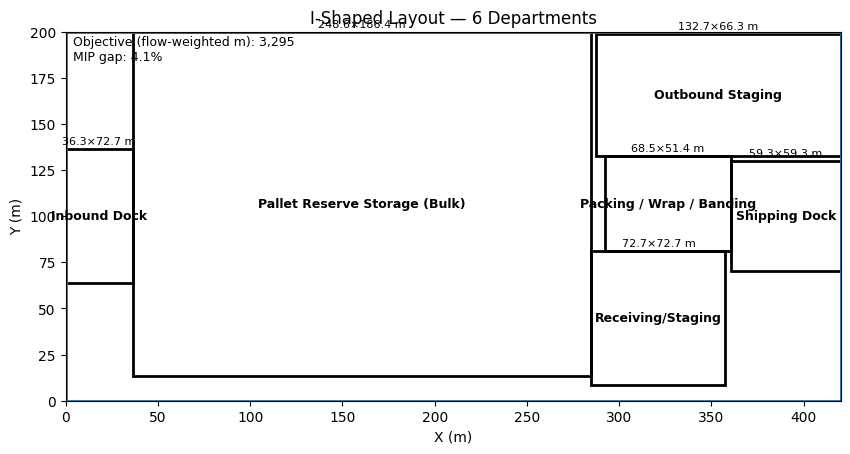

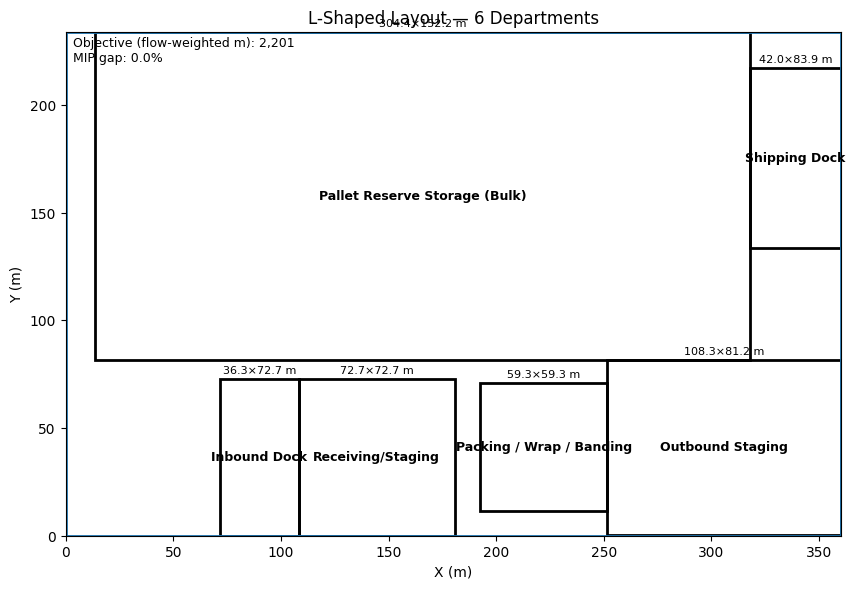

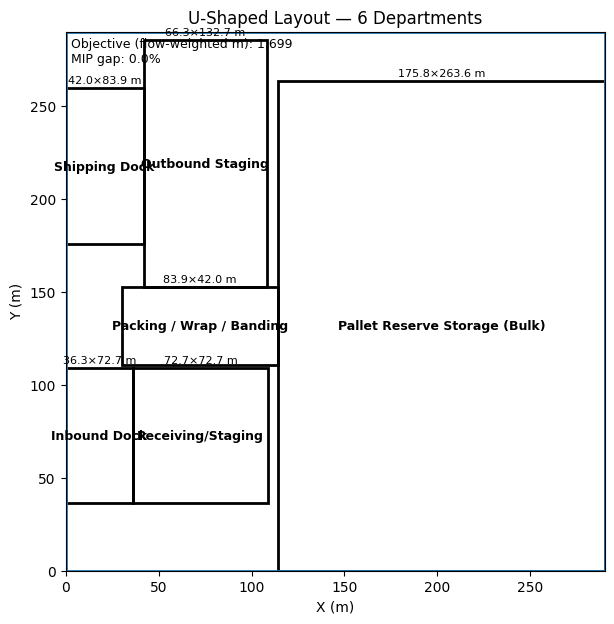

In [ ]:
draw_layout(sol_I, title="I-Shaped Layout — 6 Departments")
draw_layout(sol_L, title="L-Shaped Layout — 6 Departments")
draw_layout(sol_U, title="U-Shaped Layout — 6 Departments")


## Quick comparison
We list objective values (lower is better).


In [ ]:
summary = [
    (sol_I["name"], sol_I["obj"], sol_I.get("gap", None)),
    (sol_L["name"], sol_L["obj"], sol_L.get("gap", None)),
    (sol_U["name"], sol_U["obj"], sol_U.get("gap", None)),
]
for name, obj, gap in summary:
    if obj is None:
        print(f"{name:10s} : infeasible or no solution")
    else:
        gap_txt = f" (gap {gap*100:.1f}%)" if (gap is not None and gap >= 0) else ""
        print(f"{name:10s} : {obj:,.0f}{gap_txt}")


I-shaped   : 3,295 (gap 4.1%)
L-shaped   : 2,201 (gap 0.0%)
U-shaped   : 1,699 (gap 0.0%)
